# Imports and configs

In [1]:
!pip install -q autogluon.tabular ray==2.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
aiobotocore 2.15.0 requires botocore<1.35.17,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libp

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    original_data_path = '/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859
    time_limit = 3600 * 5

# Loading data and predefining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')
original = pd.read_csv(CFG.original_data_path)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    log_file_path='logs.txt',
    log_to_file=True,
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241006_153546"


In [7]:
predictor.fit_pseudolabel(
    train_data=train,
    pseudo_data=original,
    time_limit=CFG.time_limit,
    presets='best_quality',
    excluded_model_types=['KNN', 'NN', 'XT', 'FASTAI', 'NN_TORCH'],
    ag_args_fit={
        'num_gpus': 1, 
        'num_cpus': 4
    }
)

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       30.20 GB / 31.36 GB (96.3%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

(_ray_fit pid=359) [1000]	valid_set's binary_logloss: 0.169026


(_ray_fit pid=407) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=407) [1000]	valid_set's binary_logloss: 0.160595
(_ray_fit pid=407) [2000]	valid_set's binary_logloss: 0.160742


(_ray_fit pid=455) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=455) [1000]	valid_set's binary_logloss: 0.168161


(_ray_fit pid=503) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=503) [1000]	valid_set's binary_logloss: 0.164865


(_ray_fit pid=551) 	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=551) [1000]	valid_set's binary_logloss: 0.166816


(_dystack pid=168) 	0.94	 = Validation score   (roc_auc)
(_dystack pid=168) 	65.92s	 = Training   runtime
(_dystack pid=168) 	2.25s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_BAG_L1 ... Training model for up to 2923.26s of the 4422.28s of remaining time.
(_dystack pid=168) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=4, gpus=1, memory=0.08%)
(_ray_fit pid=612) 	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=660) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=708) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=756) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=804) 	Training S1F5 with GPU, note that this may negatively impact model 

(_ray_fit pid=2562) [1000]	valid_set's binary_logloss: 0.149813


(_ray_fit pid=2610) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=2610) [1000]	valid_set's binary_logloss: 0.144681


(_ray_fit pid=2658) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=2658) [1000]	valid_set's binary_logloss: 0.149725


(_ray_fit pid=2706) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=2706) [1000]	valid_set's binary_logloss: 0.147778


(_ray_fit pid=2754) 	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=2754) [1000]	valid_set's binary_logloss: 0.150357


(_dystack pid=168) 	0.9575	 = Validation score   (roc_auc)
(_dystack pid=168) 	77.2s	 = Training   runtime
(_dystack pid=168) 	2.36s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 2145.15s of the 3644.17s of remaining time.
(_dystack pid=168) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=4, gpus=1, memory=0.13%)
(_ray_fit pid=2814) 	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=2814) 	Warning: CatBoost on GPU is experimental. If you encounter issues, use CPU for training CatBoost instead.
(_ray_fit pid=2887) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=2887) 	Warning: CatBoost on GPU is experimental. If you encounter issues, use CPU for training CatBoost instead.
(_ray_fit pid=2960) 	Training S1F3 with GPU, note that this may negat

(_ray_fit pid=3191) [1000]	valid_set's binary_logloss: 0.18023
(_ray_fit pid=3191) [2000]	valid_set's binary_logloss: 0.173055
(_ray_fit pid=3191) [3000]	valid_set's binary_logloss: 0.170083
(_ray_fit pid=3191) [4000]	valid_set's binary_logloss: 0.168423
(_ray_fit pid=3191) [5000]	valid_set's binary_logloss: 0.167672
(_ray_fit pid=3191) [6000]	valid_set's binary_logloss: 0.166789
(_ray_fit pid=3191) [7000]	valid_set's binary_logloss: 0.166367
(_ray_fit pid=3191) [8000]	valid_set's binary_logloss: 0.165867
(_ray_fit pid=3191) [9000]	valid_set's binary_logloss: 0.16542
(_ray_fit pid=3191) [10000]	valid_set's binary_logloss: 0.165218


(_ray_fit pid=3239) 	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=3239) [1000]	valid_set's binary_logloss: 0.173525
(_ray_fit pid=3239) [2000]	valid_set's binary_logloss: 0.166858
(_ray_fit pid=3239) [3000]	valid_set's binary_logloss: 0.163646
(_ray_fit pid=3239) [4000]	valid_set's binary_logloss: 0.162223
(_ray_fit pid=3239) [5000]	valid_set's binary_logloss: 0.160998
(_ray_fit pid=3239) [6000]	valid_set's binary_logloss: 0.160033
(_ray_fit pid=3239) [7000]	valid_set's binary_logloss: 0.15929
(_ray_fit pid=3239) [8000]	valid_set's binary_logloss: 0.158806
(_ray_fit pid=3239) [9000]	valid_set's binary_logloss: 0.158412
(_ray_fit pid=3239) [10000]	valid_set's binary_logloss: 0.158158


(_ray_fit pid=3287) 	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=3287) [1000]	valid_set's binary_logloss: 0.176866
(_ray_fit pid=3287) [2000]	valid_set's binary_logloss: 0.170368
(_ray_fit pid=3287) [3000]	valid_set's binary_logloss: 0.167948
(_ray_fit pid=3287) [4000]	valid_set's binary_logloss: 0.166412
(_ray_fit pid=3287) [5000]	valid_set's binary_logloss: 0.16539
(_ray_fit pid=3287) [6000]	valid_set's binary_logloss: 0.16493
(_ray_fit pid=3287) [7000]	valid_set's binary_logloss: 0.164624
(_ray_fit pid=3287) [8000]	valid_set's binary_logloss: 0.164244
(_ray_fit pid=3287) [9000]	valid_set's binary_logloss: 0.164054
(_ray_fit pid=3287) [10000]	valid_set's binary_logloss: 0.164001


(_ray_fit pid=3335) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=3335) [1000]	valid_set's binary_logloss: 0.177185
(_ray_fit pid=3335) [2000]	valid_set's binary_logloss: 0.170021
(_ray_fit pid=3335) [3000]	valid_set's binary_logloss: 0.167059
(_ray_fit pid=3335) [4000]	valid_set's binary_logloss: 0.165584
(_ray_fit pid=3335) [5000]	valid_set's binary_logloss: 0.164453
(_ray_fit pid=3335) [6000]	valid_set's binary_logloss: 0.163915
(_ray_fit pid=3335) [7000]	valid_set's binary_logloss: 0.163305
(_ray_fit pid=3335) [8000]	valid_set's binary_logloss: 0.16295
(_ray_fit pid=3335) [9000]	valid_set's binary_logloss: 0.162873
(_ray_fit pid=3335) [10000]	valid_set's binary_logloss: 0.162677


(_ray_fit pid=3383) 	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


(_ray_fit pid=3383) [1000]	valid_set's binary_logloss: 0.180961
(_ray_fit pid=3383) [2000]	valid_set's binary_logloss: 0.172797
(_ray_fit pid=3383) [3000]	valid_set's binary_logloss: 0.169471
(_ray_fit pid=3383) [4000]	valid_set's binary_logloss: 0.167549
(_ray_fit pid=3383) [5000]	valid_set's binary_logloss: 0.166426
(_ray_fit pid=3383) [6000]	valid_set's binary_logloss: 0.165684
(_ray_fit pid=3383) [7000]	valid_set's binary_logloss: 0.165148
(_ray_fit pid=3383) [8000]	valid_set's binary_logloss: 0.164777
(_ray_fit pid=3383) [9000]	valid_set's binary_logloss: 0.164652
(_ray_fit pid=3383) [10000]	valid_set's binary_logloss: 0.164461


(_dystack pid=168) 	0.9427	 = Validation score   (roc_auc)
(_dystack pid=168) 	217.36s	 = Training   runtime
(_dystack pid=168) 	17.91s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 1810.7s of the 3309.72s of remaining time.
(_dystack pid=168) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=4, gpus=1, memory=0.21%)
(_ray_fit pid=3443) /opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:55:42] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
(_ray_fit pid=3443)   warnings.warn(smsg, UserWarning)
(_ray_fit pid=3443) /opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:55:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.


(_ray_fit pid=7639) [1000]	valid_set's binary_logloss: 0.149148


(_ray_fit pid=7687) 	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.
(_ray_fit pid=7735) 	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.
(_dystack pid=168) 	0.9577	 = Validation score   (roc_auc)
(_dystack pid=168) 	37.12s	 = Training   runtime
(_dystack pid=168) 	0.7s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 802.83s of the 802.77s of remaining time.
(_dystack pid=168) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=4, gpus=1, memory=0.44%)
(_ray_fit pid=7801) /opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:37:29] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
(_ray_fit pid=7801)   warnings.warn(smsg, UserWarning)
(_ray_fit pid=7801) /opt/conda/l

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_PSEUDO,0.963588,roc_auc,14.628051,838.784605,0.009027,4.146763,2,True,112
1,LightGBM_r121_BAG_L1_PSEUDO,0.962620,roc_auc,5.319407,243.827448,5.319407,243.827448,1,True,103
2,LightGBM_r161_BAG_L1_PSEUDO,0.962358,roc_auc,4.818531,230.571919,4.818531,230.571919,1,True,78
3,LightGBM_r15_BAG_L1_PSEUDO,0.962248,roc_auc,6.107877,142.846757,6.107877,142.846757,1,True,84
4,LightGBM_r131_BAG_L1_PSEUDO,0.962112,roc_auc,4.771057,139.897369,4.771057,139.897369,1,True,65
5,LightGBM_r130_BAG_L1_PSEUDO,0.962100,roc_auc,0.917143,47.827622,0.917143,47.827622,1,True,74
6,XGBoost_r31_BAG_L1_PSEUDO,0.961296,roc_auc,0.513671,114.269815,0.513671,114.269815,1,True,97
7,LightGBM_BAG_L1_PSEUDO,0.961294,roc_auc,0.999092,44.450782,0.999092,44.450782,1,True,58
8,XGBoost_r89_BAG_L1_PSEUDO,0.961002,roc_auc,0.162437,23.768325,0.162437,23.768325,1,True,73
9,XGBoost_r22_BAG_L1_PSEUDO,0.960774,roc_auc,0.182922,22.800912,0.182922,22.800912,1,True,101


# Visualizing the ensemble weights

In [9]:
def get_ensemble_weights():
    ensemble_weights = {}
    with open('logs.txt', 'rb') as f:
        prev_line = b''
        for line in f.readlines():
            if b'Ensemble Weights:' in line:
                name = prev_line.split(b'Fitting model: ')[1]
                name = name.split(b'...')[0]
                name = name.decode('utf-8')
                temp_ensemble_weights = line.split(b'Ensemble Weights: ')[1]
                temp_ensemble_weights = temp_ensemble_weights.split(b'\n')[0]
                temp_ensemble_weights = eval(temp_ensemble_weights)
                ensemble_weights[name] = temp_ensemble_weights
            prev_line = line
    return ensemble_weights

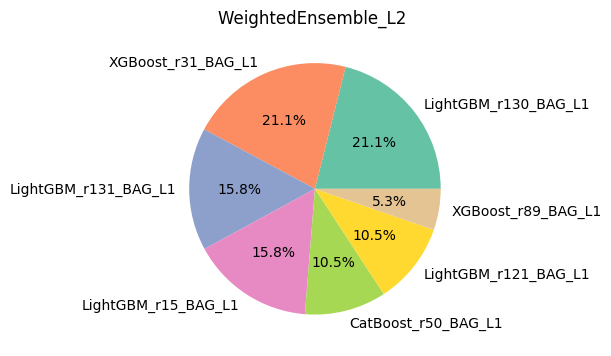

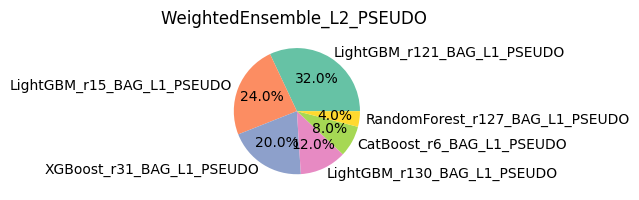

In [10]:
ensemble_weights = get_ensemble_weights()

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

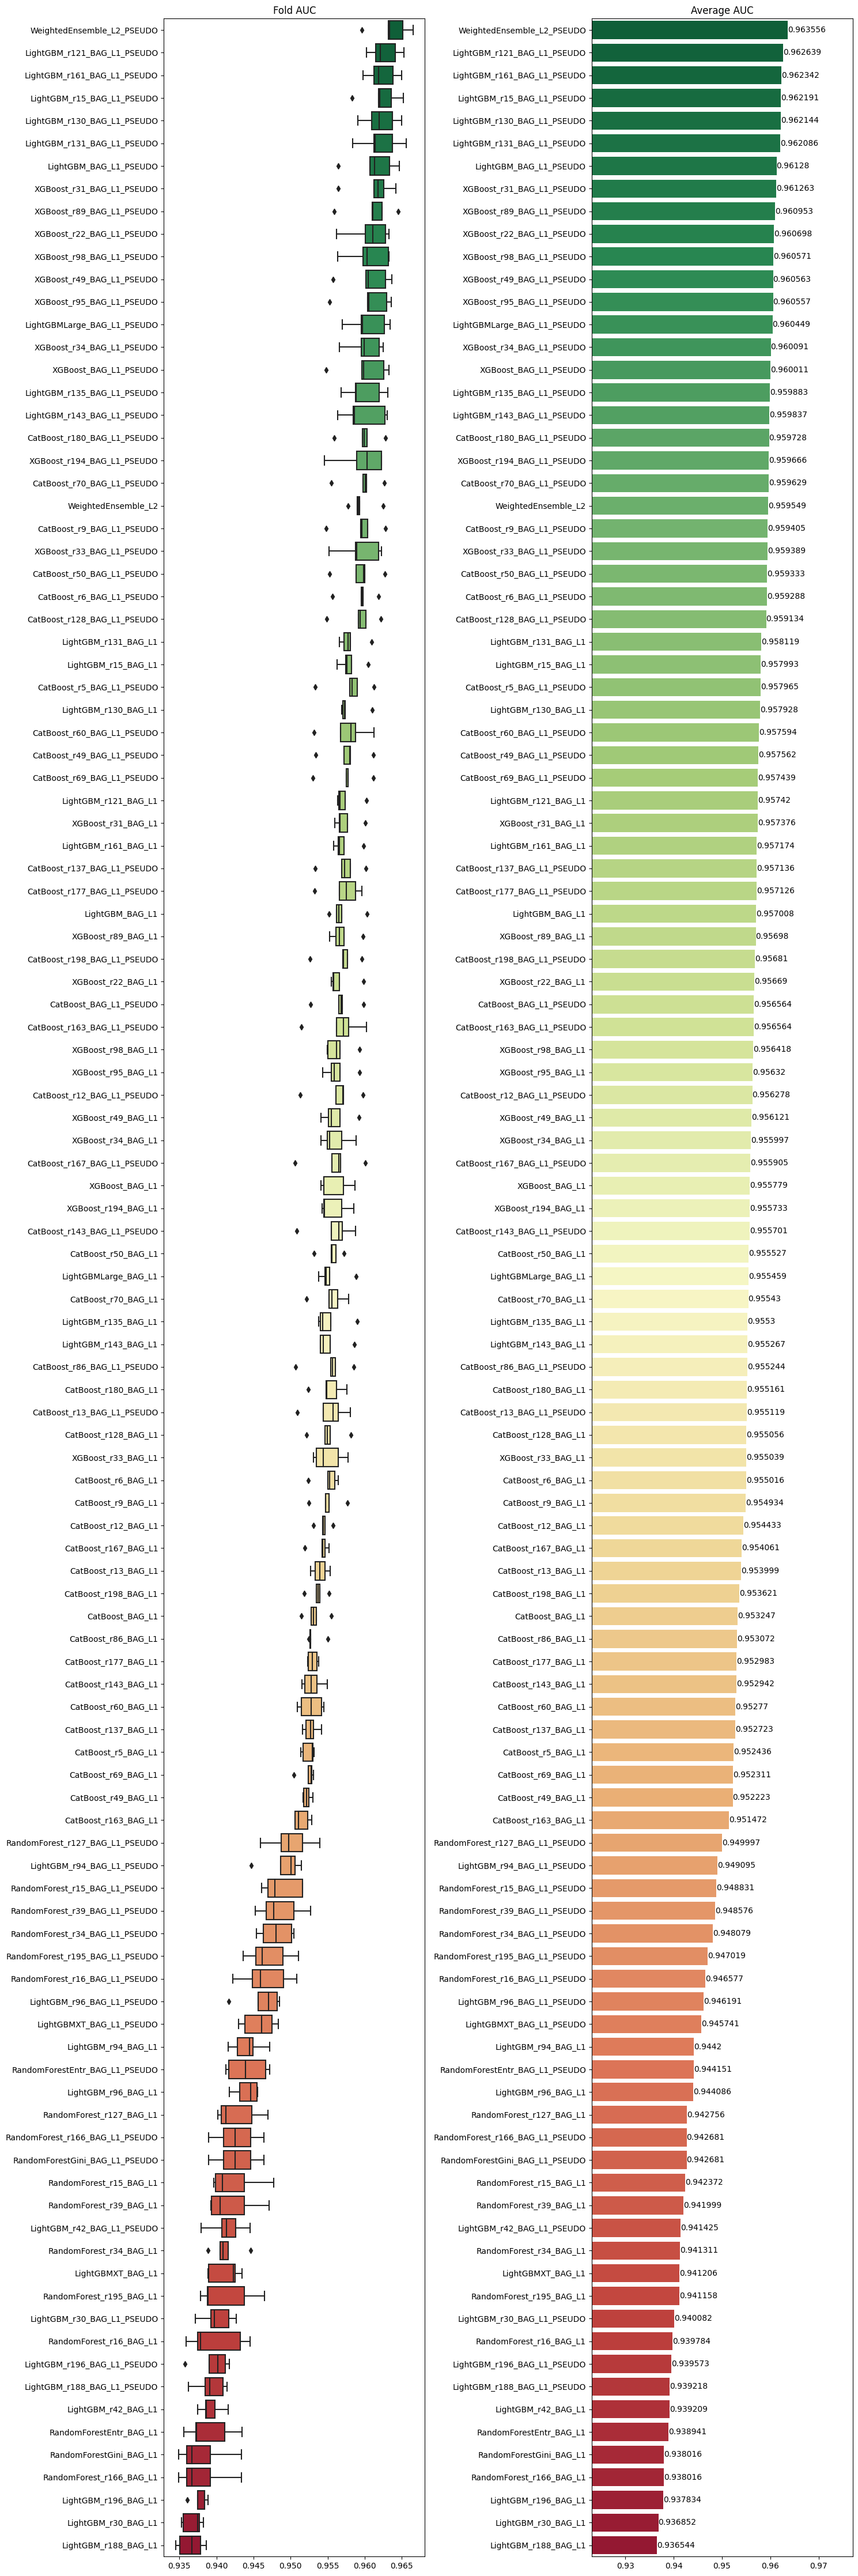

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [16]:
shutil.rmtree("AutogluonModels")